---
# Module Dependency

In [1]:
%matplotlib inline
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
from torch.autograd import Variable
import pandas as pd
from skimage import io, transform, color, morphology
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

plt.rcParams['figure.figsize'] = (10.0, 8.0)

---
# Define Constant

In [2]:
tqdm.monitor_interval = 0
USE_GPU = torch.cuda.is_available()
TRAIN_DATA_PATH = '/media/dennis/HDD/AerialImageDataset/train/512/train_data/'
TRAIN_LABEL_PATH = '/media/dennis/HDD/AerialImageDataset/train/512/train_label/'
VAL_DATA_PATH = '/media/dennis/HDD/AerialImageDataset/train/512/val_data/'
VAL_LABEL_PATH = '/media/dennis/HDD/AerialImageDataset/train/512/val_label/'

---
# Load data and data preprocessing

In [3]:
"""
Get file names of training and testing data
"""
train = (os.listdir(TRAIN_DATA_PATH), os.listdir(TRAIN_LABEL_PATH))
val = (os.listdir(VAL_DATA_PATH), os.listdir(VAL_LABEL_PATH))
print(len(train[0]), len(train[1]))
print(len(val[0]), len(val[1]))

17100 17100
900 900


In [4]:
"""
Create dataset object to load aerial data
"""
class AerialImageDataset(Dataset):
    """
    It is used to load the aerial image dataset 
    """
    def __init__(self, data_dir, label_dir, data_list, label_list, transform=None):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.datas = data_list
        self.labels = label_list
        self.transform = transform
    def __len__(self):
        return len(self.datas)
    def __getitem__(self, idx):
        img_name = self.data_dir + str(self.datas[idx])
        lbl_name = self.label_dir + str(self.labels[idx])
        img = io.imread(img_name)
        lbl = io.imread(lbl_name)
        if self.transform:
            img = self.transform(img)
            lbl = transforms.ToPILImage()(np.expand_dims(lbl, axis=2))
#             lbl = transforms.Resize((512, 512))(lbl)
            lbl = transforms.ToTensor()(lbl)
            lbl[lbl >= 0.5] = 1
            lbl[lbl < 0.5] = 0
        return (img, lbl)

In [5]:
"""
Build training dataset containing data and label,
both of them are in torch.Tensor data type.
"""
train_dataset = AerialImageDataset(
    data_dir = TRAIN_DATA_PATH,
    label_dir = TRAIN_LABEL_PATH,
    data_list = train[0],
    label_list = train[1],
    transform = transforms.Compose([
        transforms.ToPILImage(),
#         transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
# fig, axs = plt.subplots(2)
# axs[0].imshow(train_dataset[30][0])
# axs[1].imshow(train_dataset[30][1])
print(train_dataset[17099][0].size())
print(train_dataset[17099][1].size())

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


In [6]:
"""
Build Val dataset containing data and label,
both of them are in torch.Tensor data type.
"""
val_dataset = AerialImageDataset(
    data_dir = VAL_DATA_PATH,
    label_dir = VAL_LABEL_PATH,
    data_list = val[0],
    label_list = val[1],
    transform = transforms.Compose([
        transforms.ToPILImage(),
#         transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
print(val_dataset[899][0].size())
print(val_dataset[899][1].size())

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


In [7]:
"""
Build dataloader for both training and val data,
the size of training data will be [4, 3, 500, 500]
the size of val data will be [4, 1, 500, 500]
"""
train_dataloader = DataLoader(train_dataset, 4, shuffle=True)
val_dataloader = DataLoader(val_dataset, 4)

---
# Build Network

In [8]:
from model_test import PSPNet, PSPModule, PSPUpsample

In [9]:
densenet121 = models.densenet121(pretrained=True)
print(densenet121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [10]:
print(list(densenet121.features.children())[0:4])

[Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True), ReLU(inplace), MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))]


In [41]:
def train_model(model, criterion, optimizer, num_epochs=8):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.9568

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train(True)
        running_loss = 0.0
        running_acc = 0.0
        # Iterate over data.
        for i, data in tqdm_notebook(enumerate(train_dataloader), total=2001):
            if(i == 2000):
                break
            # get the inputs
            inputs, labels = data[0], data[1]
            # wrap them in Variable
            if USE_GPU:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            predict = outputs.data > 0.5
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.data[0]
            running_acc += (torch.sum(predict.int() == labels.data.int())/(4*512*512))
        epoch_loss = running_loss / 2000
        epoch_acc = running_acc / 2000
        print('{} Loss: {:.4f}, Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
#         if epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = model.state_dict()
        
        model.eval()
        running_loss = 0.0
        running_acc = 0.0
        # Iterate over data.
        for i, data in enumerate(val_dataloader):
            # get the inputs
            inputs, labels = data[0], data[1]
            # wrap them in Variable
            if USE_GPU:
                inputs = Variable(inputs.cuda(), volatile=True)
                labels = Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            predict = outputs.data > 0.5
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.data[0]
            running_acc += torch.sum(predict.int() == labels.data.int())/(4*512*512)
        epoch_loss = running_loss / len(val_dataloader)
        epoch_acc = running_acc / len(val_dataloader)
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
            torch.save(model, './temp.pt')
        print('{} Loss: {:.4f}, Acc: {:.4f}'.format('val', epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

---
# Training

In [12]:
model = PSPNet(densenet121)
if USE_GPU:
    model.cuda()
print(model)

PSPNet(
  (feature1): Sequential(
    (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  )
  (feature2): Sequential(
    (0): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [13]:
criterion = nn.BCELoss()
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters())

In [42]:
model, acc = train_model(model, criterion, optimizer, 20)

Epoch 0/19
----------


A Jupyter Widget


train Loss: 0.1080, Acc: 0.9584
val Loss: 0.1138, Acc: 0.9560

Epoch 1/19
----------


A Jupyter Widget


train Loss: 0.1087, Acc: 0.9583
val Loss: 0.1148, Acc: 0.9556

Epoch 2/19
----------


A Jupyter Widget


train Loss: 0.1084, Acc: 0.9582
val Loss: 0.1210, Acc: 0.9529

Epoch 3/19
----------


A Jupyter Widget


train Loss: 0.1066, Acc: 0.9589
val Loss: 0.1146, Acc: 0.9557

Epoch 4/19
----------


A Jupyter Widget


train Loss: 0.1053, Acc: 0.9593
val Loss: 0.1114, Acc: 0.9583

Epoch 5/19
----------


A Jupyter Widget


train Loss: 0.1040, Acc: 0.9599
val Loss: 0.1080, Acc: 0.9590

Epoch 6/19
----------


A Jupyter Widget


train Loss: 0.1052, Acc: 0.9594
val Loss: 0.1083, Acc: 0.9582

Epoch 7/19
----------


A Jupyter Widget


train Loss: 0.1043, Acc: 0.9597
val Loss: 0.1104, Acc: 0.9575

Epoch 8/19
----------


A Jupyter Widget


train Loss: 0.1014, Acc: 0.9609
val Loss: 0.1113, Acc: 0.9575

Epoch 9/19
----------


A Jupyter Widget


train Loss: 0.1001, Acc: 0.9613
val Loss: 0.1151, Acc: 0.9555

Epoch 10/19
----------


A Jupyter Widget


train Loss: 0.1014, Acc: 0.9607
val Loss: 0.1078, Acc: 0.9584

Epoch 11/19
----------


A Jupyter Widget


train Loss: 0.1005, Acc: 0.9612
val Loss: 0.1082, Acc: 0.9586

Epoch 12/19
----------


A Jupyter Widget


train Loss: 0.1000, Acc: 0.9614
val Loss: 0.1062, Acc: 0.9591

Epoch 13/19
----------


A Jupyter Widget


train Loss: 0.0988, Acc: 0.9618
val Loss: 0.1070, Acc: 0.9591

Epoch 14/19
----------


A Jupyter Widget


train Loss: 0.0992, Acc: 0.9616
val Loss: 0.1180, Acc: 0.9545

Epoch 15/19
----------


A Jupyter Widget


train Loss: 0.0961, Acc: 0.9627
val Loss: 0.1022, Acc: 0.9607

Epoch 16/19
----------


A Jupyter Widget


train Loss: 0.0943, Acc: 0.9635
val Loss: 0.1064, Acc: 0.9591

Epoch 17/19
----------


A Jupyter Widget


train Loss: 0.0980, Acc: 0.9618
val Loss: 0.1076, Acc: 0.9588

Epoch 18/19
----------


A Jupyter Widget


train Loss: 0.0971, Acc: 0.9623
val Loss: 0.1083, Acc: 0.9585

Epoch 19/19
----------


A Jupyter Widget


train Loss: 0.0916, Acc: 0.9645
val Loss: 0.1115, Acc: 0.9581

Training complete in 275m 26s


In [43]:
torch.save(model, './model-0113-test-40ep-{:.4f}.pt'.format(acc))

---
# Test Model

In [16]:
# from model_old import PSPNet, PSPModule, PSPUpsample

In [17]:
# model = PSPNet(densenet161)
# model = torch.load('./model-1226-0.9504.pt')

In [64]:
test = val_dataset[100]
print(test[0].size(), test[1].size())

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


In [65]:
inputs, labels = test
inputs = inputs.unsqueeze(0)
labels = labels.unsqueeze(0)
if USE_GPU:
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())
else:
    inputs, labels = Variable(inputs), Variable(labels)
print(inputs.size(), labels.size())

torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])


In [66]:
model.eval()
outputs = model(inputs)
print(outputs)

Variable containing:
( 0 , 0 ,.,.) = 
  9.6276e-02  1.2578e-01  1.2315e-01  ...   2.0742e-03  2.4705e-03  3.4163e-03
  1.6298e-01  1.4478e-01  1.4393e-01  ...   1.9226e-03  3.2985e-03  2.7755e-03
  2.2481e-01  2.2659e-01  2.1820e-01  ...   8.5547e-04  1.2676e-03  1.4645e-03
                 ...                   ⋱                   ...                
  6.2597e-04  2.4564e-04  3.5389e-04  ...   2.1048e-03  2.3447e-03  3.1076e-03
  5.8057e-04  2.2055e-04  2.1046e-04  ...   1.4319e-03  1.5015e-03  2.6970e-03
  1.5943e-03  6.8429e-04  5.2811e-04  ...   2.4448e-03  1.9519e-03  5.1587e-03
[torch.cuda.FloatTensor of size 1x1x512x512 (GPU 0)]



In [67]:
outputs = transforms.ToPILImage()(outputs.data.cpu()[0])
outputs = np.array(outputs)
labels = transforms.ToPILImage()(labels.data.cpu()[0])
labels = np.array(labels)
print(outputs.shape)
print(labels.shape)

(512, 512)
(512, 512)


In [68]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

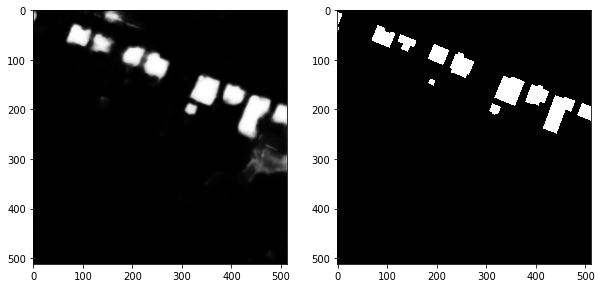

In [69]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(outputs, cmap='gray')
axs[1].imshow(labels, cmap='gray')

In [63]:
val_dataset.datas[1]

'0.tif'

In [41]:
val_dataset.labels[2]

'1.tif'

In [38]:
val[0].index('46.tif')

119